In [1]:
%load_ext autoreload
%autoreload 2
from geolifeclef.utils import get_spark
from pyspark.sql import functions as F

spark = get_spark(memory="24g", executor_memory="1g")
metadata = spark.read.parquet(
    "../../data/geolifeclef-2024/data/processed/metadata_clean/v1"
)
metadata.printSchema()
metadata.show()

24/04/29 07:29:37 WARN Utils: Your hostname, daphne-major resolves to a loopback address: 127.0.1.1; using 172.28.199.217 instead (on interface eth0)
24/04/29 07:29:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/29 07:29:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/29 07:29:39 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


root
 |-- dataset: string (nullable = true)
 |-- surveyId: integer (nullable = true)
 |-- lat_proj: double (nullable = true)
 |-- lon_proj: double (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- geoUncertaintyInM: double (nullable = true)
 |-- speciesId: double (nullable = true)

+--------+--------+-------------------+--------------------+---------+---------+----+-----------------+---------+
| dataset|surveyId|           lat_proj|            lon_proj|      lat|      lon|year|geoUncertaintyInM|speciesId|
+--------+--------+-------------------+--------------------+---------+---------+----+-----------------+---------+
|pa_train| 1154667|-1532011.0411057267| 1.691006027258277E7| 57.41102|  10.1656|2018|             10.0|   5928.0|
|      po|  328943|-1238969.8380109437|1.6157490707117997E7| 52.66047|  19.0257|2021|              4.0|   8654.0|
|      po|  272993| -3131000.345551669|1.5794519571905952E7| 42.706

In [2]:
from pyspark.ml.linalg import SparseVector, VectorUDT
from collections import Counter


def _collect_sparse_labels(array):
    """Turn a list of numbers into a sparse vector."""
    max_species = 11255

    @F.udf(VectorUDT())
    def func(array):
        if not array:
            return SparseVector(max_species, [])
        return SparseVector(max_species, sorted(Counter(array).items()))

    return func(array)


df = (
    (
        metadata.where(F.col("dataset") == "pa_train")
        .groupBy("surveyId")
        .agg(
            F.mean("lat_proj").alias("lat_proj"),
            F.mean("lon_proj").alias("lon_proj"),
            _collect_sparse_labels(F.collect_list("speciesId")).alias("labels_sp"),
            F.sort_array(F.collect_set("speciesId")).alias("labels"),
        )
        .withColumn("sample_id", F.crc32(F.col("surveyId").cast("string")) % 100)
        .withColumn("is_validation", F.col("sample_id") < 10)
        .withColumn("is_train", F.col("sample_id") < 80)
        .withColumn("is_test", F.col("sample_id") >= 80)
    )
    .orderBy("surveyId")
    .cache()
)
print(df.count())
df.show()

88987
+--------+-------------------+--------------------+--------------------+--------------------+---------+-------------+--------+-------+
|surveyId|           lat_proj|            lon_proj|           labels_sp|              labels|sample_id|is_validation|is_train|is_test|
+--------+-------------------+--------------------+--------------------+--------------------+---------+-------------+--------+-------+
|     212|-2901099.7073597685|1.5712712997500205E7|(11255,[51,476,98...|[51.0, 476.0, 982...|       82|        false|   false|   true|
|     222|-1577042.7181193172| 1.686875248622122E7|(11255,[254,433,5...|[254.0, 433.0, 54...|       73|        false|    true|  false|
|     243|-1745905.7764134756| 1.679526716269353E7|(11255,[129,254,1...|[129.0, 254.0, 13...|       89|        false|   false|   true|
|     324|-3149612.3055191883|1.5932557464872137E7|(11255,[146,694,2...|[146.0, 694.0, 23...|       19|        false|    true|  false|
|     333|-2985718.7817890504|1.6179947656697601E

In [3]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA

scaled_labels = (
    StandardScaler(
        inputCol="labels_sp", outputCol="labels_centered", withStd=False, withMean=True
    )
    .fit(df)
    .transform(df)
)

In [4]:
# compute svd using the labels_sp column
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.mllib.linalg import Vectors
from contexttimer import Timer

# convert to a sparse matrix
X = RowMatrix(
    scaled_labels.rdd.map(lambda x: Vectors.fromML(x.labels_centered)).cache()
)
with Timer() as t:
    svd = X.computeSVD(2, computeU=True)
    print(svd.s)
    print(svd.V.toArray().shape)
    print(svd.U.rows)
    # pca = X.computePrincipalComponents(16)
    # print(pca)

print(f"svd computed in {t.elapsed:.2f}s")

24/04/29 07:30:21 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 30 (TID 697): Attempting to kill Python Worker
24/04/29 07:30:21 WARN RowMatrix: The input data is not directly cached, which may hurt performance if its parent RDDs are also uncached.


[324.16952924662274,261.938272376485]
(11255, 2)
MapPartitionsRDD[169] at mapPartitions at PythonMLLibAPI.scala:1344
svd computed in 951.50s


24/04/29 07:46:07 WARN RowMatrix: The input data was not directly cached, which may hurt performance if its parent RDDs are also uncached.


In [5]:
labels_svd = (
    svd.U.rows.zipWithIndex()
    .map(lambda x: (x[1], x[0]))
    .toDF(["index", "labels_svd"])
    .join(
        df.select("surveyId")
        .rdd.zipWithIndex()
        .map(lambda x: (x[1], x[0].surveyId))
        .toDF(["index", "surveyId"]),
        on="index",
    )
    .cache()
)
labels_svd.printSchema()
labels_svd.show(n=5, truncate=80)

root
 |-- index: long (nullable = true)
 |-- labels_svd: vector (nullable = true)
 |-- surveyId: long (nullable = true)



+-----+---------------------------------------------+--------+
|index|                                   labels_svd|surveyId|
+-----+---------------------------------------------+--------+
|   26| [0.004343498115214126,-0.003363208215765497]|    1191|
|   29|  [-7.17245831061917E-4,8.634193068591118E-4]|    1386|
|  474|[2.066592609943839E-4,-2.4705978577512107E-4]|   21721|
|  964| [-0.0030182006426398927,9.32739118855535E-4]|   42555|
| 1677|[-1.5598121064664387E-4,8.386758741235021E-4]|   76148|
+-----+---------------------------------------------+--------+
only showing top 5 rows



(88987, 2)


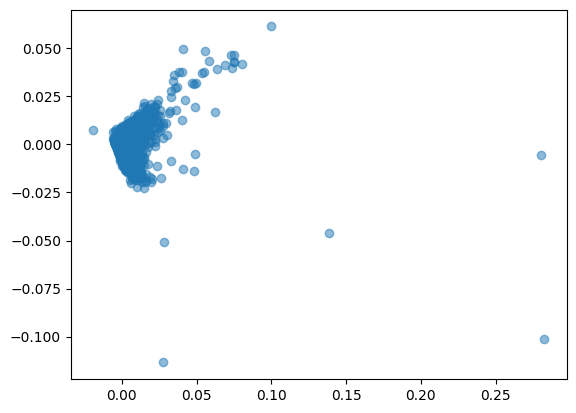

In [6]:
import matplotlib.pyplot as plt
import numpy as np

U = np.stack(labels_svd.toPandas().labels_svd)
print(U.shape)
plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()

In [7]:
from pynndescent import NNDescent

index = NNDescent(U, metric="cosine")

In [8]:
# test a query
indices, distances = index.query(U[:1], k=10)
print(indices, distances)

/home/anthony/omscs/dsgt-clef/venv/lib/python3.11/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[[ 5787     0  2919 31210 60389 56827  6184 18025 25239 64167]] [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.19209271e-07 1.19209271e-07
  2.38418528e-07 2.38418528e-07]]
